In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import epde.interface.interface as epde_alg
from epde.interface.prepared_tokens import CustomTokens, CacheStoredTokens

In [2]:
data=pd.read_csv('../DATA-MINING/OTHER-DATA/TRANS/trans_big.csv')
data['TRANS_DATE']=pd.to_datetime(data.date)
vallab=['food', 'outfit', 'dwelling', 'health','beauty', 'remote', 'travel','money', 'kids', 'nonfood', 'telecom', 'fun', 'charity', 'misc']
data=data[np.in1d(data.group.values, vallab)]
data.sort_values(by='date', inplace=True, ignore_index=True)
data

,client,card,date,amt,mcc,group,value,TRANS_DATE
0,390989,3048567,2018-01-01,878.00,5814,food,survival,2018-01-01
1,1496081,2543555,2018-01-01,495.60,5499,food,survival,2018-01-01
2,2028714,2725479,2018-01-01,30000.00,6538,money,money,2018-01-01
3,1049186,366339,2018-01-01,619.00,5499,food,survival,2018-01-01
4,2625093,3267785,2018-01-01,1596.36,5411,food,survival,2018-01-01
...,...,...,...,...,...,...,...,...
19026857,2299058,5951962,2022-08-15,17000.00,6011,money,money,2022-08-15
19026858,1108,6297815,2022-08-15,11000.00,6011,money,money,2022-08-15
19026859,2513687,5688345,2022-08-15,7600.00,6011,money,money,2022-08-15
19026860,1324575,6304255,2022-08-15,370.00,5814,food,survival,2022-08-15


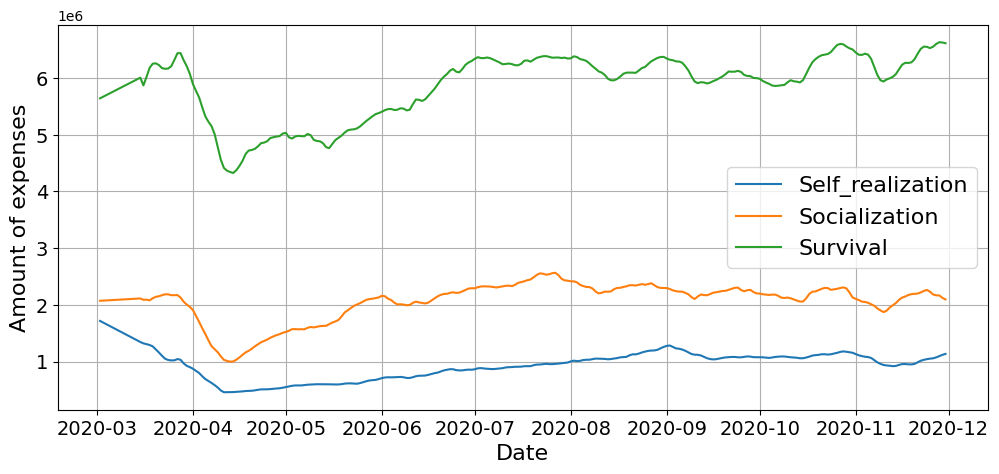

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
data['idate']=pd.to_datetime(data.date)
#[(data.date>'2020-02-26')&(data.date<'2020-03-30')][(data.date>'2022-02-22')&(data.date<'2022-03-30')]
d=data[(data.date>'2020-03-01')&(data.date<'2020-12-01')].groupby(['idate','value']).amt.sum().unstack().fillna(method='bfill')
plt.figure(figsize=(12,5))
for c in d.columns[1:]:
    sdec=seasonal_decompose(d[c], period=14, model='additive', two_sided=False, extrapolate_trend='freq')
    plt.plot(sdec.trend, label=c.capitalize())
plt.legend(fontsize=16)    
plt.grid()
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('Date',size=16)
plt.ylabel('Amount of expenses',size=16)
plt.show()

In [6]:
d.head()

value,money,self_realization,socialization,survival
idate,,,,
2020-03-02,10049461.73,890817.73,1432264.07,4407375.33
2020-03-03,12284320.67,1041904.77,2064939.77,5106615.88
2020-03-04,9044432.64,1145389.43,1788901.93,4429023.82
2020-03-05,11117749.42,1487020.89,1698246.79,5421669.31
2020-03-06,16430241.58,1973282.34,2248633.90,6289421.33


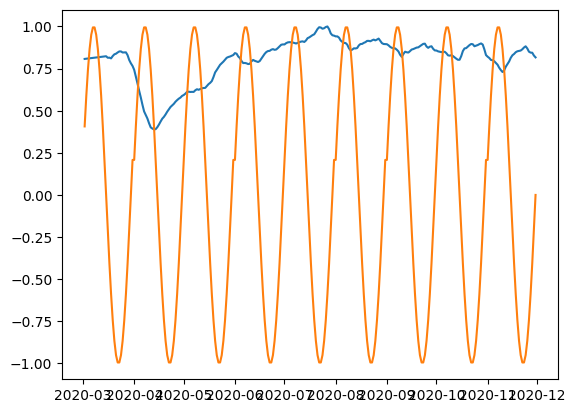

In [8]:
'''Календарь'''
u=seasonal_decompose(d['socialization'], period=14, model='addiitive', two_sided=False, extrapolate_trend='freq').trend
u/=u.max()
dsin=np.sin(u.index.day.values*2*np.pi/30)
dcos=np.cos(u.index.day.values*2*np.pi/30)
t=np.linspace(0,len(u), len(u))
plt.plot(u)
plt.plot(pd.Series(dsin, index=u.index))

In [9]:
'''Вот оно EPDE
используем на минималках, до ченго сами додумались. 
По ощущению, стреляем из пушки в воробья, нескоро и уныло, но попадает, и спасибо.
*Использование AutoML EPDE +'''
boundary = 50
dimensionality = u.ndim    
# grids = np.meshgrid(t, x, y, indexing = 'ij')
grids=np.meshgrid(t)
epde_search_obj = epde_alg.epde_search(use_solver=False, eq_search_iter = 100,
                                       dimensionality=dimensionality)
epde_search_obj.fit(data = u.values, max_deriv_order=(2), boundary = boundary, 
                    equation_terms_max_number = 3, equation_factors_max_number = 1,
                    coordinate_tensors = grids, eq_sparsity_interval = (1e-8, 5.0),
                    deriv_method='poly', deriv_method_kwargs={'smooth': True, 'grid': grids},
                    #additional_tokens = [custom_grid_tokens,],
                    memory_for_cache=25, prune_domain = False)
res=epde_search_obj.equation_search_results(only_print=0, level_num = 2)[0][0]
a,b,c = -res.structure[0].weights_final
a,b

Deriv orders after definition [[None], [0], [0, 0]]
Executing on grid with uniform nodes:
274
Start: 2023-04-04 18:51:07.371005 ; Finish: 2023-04-04 18:51:07.529624
Preprocessing runtime: 0:00:00.158619
set grids parameter is True
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
initial_shape (274,) derivs_tensor.shape (274, 2)
var_tensor.shape (274,) (174,) 50
completed grid cache with 1 tensors with labels dict_keys(['0'])
['u', 'du/dx1', 'd^2u/dx1^2']
The cardinality of defined token pool is [3]
Among them, the pool contains [3]
Creating new equation, sparsity value [0.00548514]
Equation created <class 'epde.structure.SoEq'>
New solution accepted, confirmed 1/3 solutions.
Creating new equation, sparsity value [0.01035916]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [1.80636818]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [1.76096695]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, 

Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [5.20094744e-07]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [4.42002468e-05]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [0.79222023]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [0.00016403]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [3.03429439e-06]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [9.01998121e-07]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [1.62897038]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [5.72387377e-06]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [4.0418424e-08]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [0.0009787

(0.03685814293738895, 0.0015211813184061263)

In [167]:
'''Вот тут неудобно: коэффициенты получаются в произвольном порядке. 
Оно бы хорошо, если уравнение решает тот же EPDE,
а простому человеку прихдится извращаться'''
a,b,c = -res.structure[0].weights_final
a,b,c

(0.03685814293738888, 0.0015211813184061187, -0.0013080831757448735)

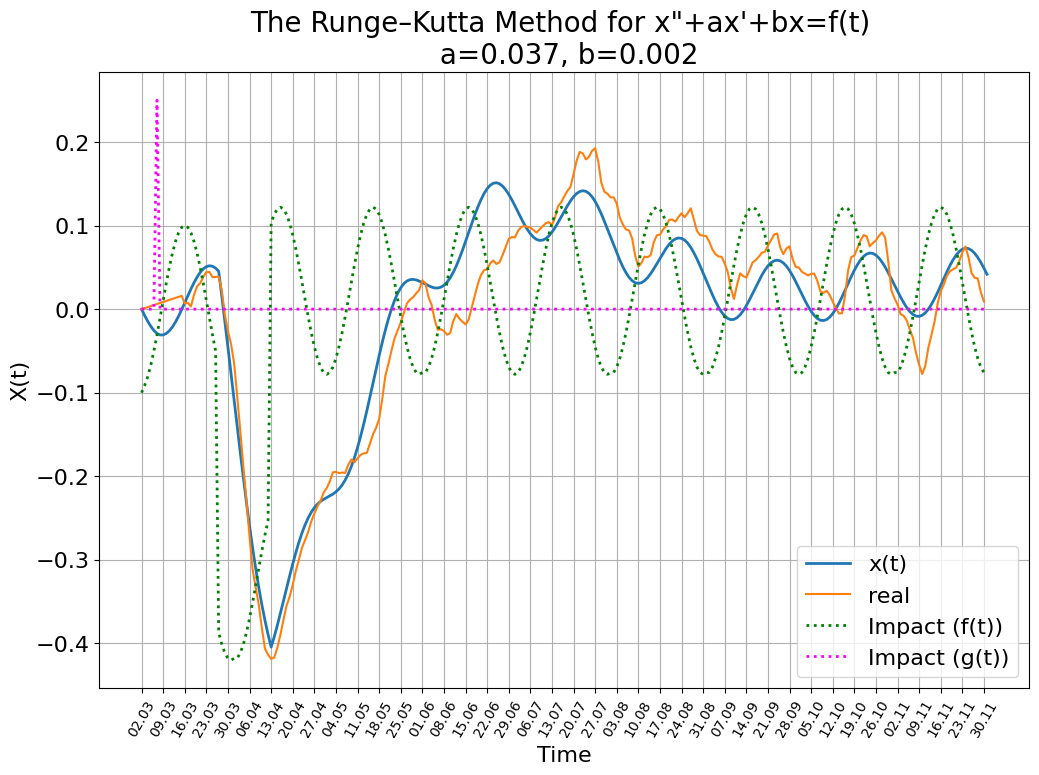

D = -0.00, h= 0.996
delta = 0.02, omega= 0.039


In [169]:
''' Рунге-Кутта IV порядка x"+ax'+bx=f(t) с начальными условиями скалярно'''
def f(t): #Внешнее воздействие по x и x'
    if t<25: #Важнее моменты. Масштаб везде условный.
        x=0
    elif t<42:
        x=-16
    else:
        x=1.1
    dx=0
    if abs(t-5)<1:
        dx+=.25
    return [x-5*dcos[int(t)-1], dx] #[f(t), g(t)]

'''Вот тут собственно процесс решения'''
x = [0.]     # Начальные условия для x(t)
dx = [0.0]    # для dx/dt
T=np.linspace(0,len(u)-1, len(u))
h=(T[-1]-T[0])/len(T)
A=np.array([[0.,1.],[-b,-a]])
for t in T:
    Y=np.array([[x[-1],dx[-1]]]).T
    k1=(np.dot(A,Y)+np.array([f(t)]).T)*h
    k2=(np.dot(A,(Y+k1/2))+np.array([f(t+h/2)]).T)*h
    k3=(np.dot(A,(Y+k2/2))+np.array([f(t+h/2)]).T)*h
    k4=(np.dot(A,(Y+k3))+np.array([f(t+h)]).T)*h
    Y1=Y+(k1+2*k2+2*k3+k4)/6
    x.append(Y1[0,0])
    dx.append(Y1[1,0])
x=np.array(x)*b 
dx=np.array(dx)*b 

'''А дальше - рисование'''
plt.figure(figsize=(12,8))
plt.plot(x, lw=2, label='x(t)')
#plt.plot(dx, lw=2, label='dx/dt')
plt.plot((u.values-u.values[0]), label='real')
plt.plot([f(t)[0]/50 for t in T], c='green', ls=':',lw=2, label='Impact (f(t))')
plt.plot([f(t)[1] for t in T], c='magenta', ls=':',lw=2, label='Impact (g(t))')
xti=np.arange(0,len(T)+1,len(T)//8)
#plt.xticks(xti, np.arange(len(xti)), size=16)
t=np.arange(0,len(u),7)
plt.xticks(t, u.index.strftime('%d.%m').values[t], rotation=60)
plt.yticks(size=16)
plt.title('The Runge–Kutta Method for x\"+ax\'+bx=f(t) \n a=%.3f, b=%.3f'%(a,b), size=20)
plt.xlabel('Time', size=16)
plt.ylabel('X(t)', size=16)
plt.legend(fontsize=16)
plt.grid()
plt.show()
print('D = %.2f, h= %.3f'%(a**2-4*b, h))
print('delta = %.2f, omega= %.3f'%(a/2, np.sqrt(b)))